In [23]:
import importlib
import utils
importlib.reload(utils)
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score, roc_auc_score, precision_score, recall_score, classification_report
import seaborn as sns
tf.test.is_built_with_cuda() #GPU aktif mi?

True

In [2]:
print("TensorFlow version:", tf.__version__)
print("GPU Build Info:", tf.sysconfig.get_build_info())
print("GPU Devices:", tf.config.list_physical_devices('GPU'))

# Bellek optimizasyonu (GPU kullanımı için)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Bellek büyümesini sınırla
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)#TensorFlow’un başlangıçta minimum bellek tahsis etmesini ve yalnızca gerektiğinde bellek kullanmasını sağlar.
    except RuntimeError as e:
        print(e)

TensorFlow version: 2.10.0
GPU Build Info: OrderedDict([('cpu_compiler', 'C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Tools/MSVC/14.29.30133/bin/HostX64/x64/cl.exe'), ('cuda_compute_capabilities', ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '64_112'), ('cudart_dll_name', 'cudart64_112.dll'), ('cudnn_dll_name', 'cudnn64_8.dll'), ('cudnn_version', '64_8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', False), ('msvcp_dll_names', 'msvcp140.dll,msvcp140_1.dll'), ('nvcuda_dll_name', 'nvcuda.dll')])
GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
#Output konsol ayarlamaları
pd.set_option('display.max_columns', None)# Tüm sütunları göster
pd.set_option('display.max_rows', None)# Tüm satırları göster
pd.set_option('display.max_colwidth', None)# Tüm sütun içeriğini gösterir.
pd.set_option("display.float_format", lambda x: '%.3f' % x)# ondalıklı sayıları 3 basamaklı şekilde kısaltır.
pd.set_option('display.width', 5000)# DataFrame oto. alta geçmesin tek satırda gösterilsin diye. 5000 karakter hakkı vardır.

In [4]:
IMG_SIZE = (224, 224)   # Güncellenmiş boyut
BATCH_SIZE = 32 # Her iterasyonda işlenecek olan gruplandırılmış görüntü sayısıdır.
EPOCHS = 30 # Modelin veriyi kaç defa işleyecek
BASE_PATH = "../TUBITAK/datasets/CSV_Multi_Label_Classification"

In [5]:
#Veri Setleri Dağılımı ve Eğitim Seti İçeriği
train_df = utils.load_data('train')
valid_df = utils.load_data('valid')
test_df = utils.load_data('test')

print(f"Train set: {len(train_df)} image")
print(f"Validation set: {len(valid_df)} image")
print(f"Test set: {len(test_df)} image")

# Etiket dağılımını kontrol et
print("Data sütunları:", train_df.columns.tolist())
print("\nEğitim seti etiket dağılımı:")
print("Moderate Accident:", train_df['moderate'].sum())
print("Severe Accident:", train_df['severe'].sum())
print("No Accident:", train_df['no_accident'].sum())
print("Multi-label (Moderate & Severe):", ((train_df['moderate'] == 1) & (train_df['severe'] == 1)).sum())

# Tensorflow Dataset'leri oluştur
train_dataset = utils.create_dataset(train_df)
valid_dataset = utils.create_dataset(valid_df)
test_dataset = utils.create_dataset(test_df)

print("\nİlk birkaç satır:")
train_df.head()

Train set: 10469 image
Validation set: 1004 image
Test set: 649 image
Data sütunları: ['filename', 'moderate', 'severe', 'no_accident']

Eğitim seti etiket dağılımı:
Moderate Accident: 3402
Severe Accident: 6853
No Accident: 259
Multi-label (Moderate & Severe): 45

İlk birkaç satır:


,filename,moderate,severe,no_accident
0,../TUBITAK/datasets/CSV_Multi_Label_Classification\train\FLIP_CAR_V160_jpg.rf.38d0202f0df2947477b997dc3386e988.jpg,1,1,0
1,../TUBITAK/datasets/CSV_Multi_Label_Classification\train\images-18_jpg.rf.3891ad2ae29961a8d9e95f1900286b9e.jpg,0,1,0
2,../TUBITAK/datasets/CSV_Multi_Label_Classification\train\images-3_jpg.rf.390be461aa11e350bf6d77d460424853.jpg,0,1,0
3,../TUBITAK/datasets/CSV_Multi_Label_Classification\train\severityV3_24_jpeg_jpg.rf.388f61747f536c0e3eeba7090719cf72.jpg,0,1,0
4,../TUBITAK/datasets/CSV_Multi_Label_Classification\train\accidentFrame3008_jpg.rf.38dba20c29c95c8fa02b82586a341ff2.jpg,1,0,0


In [6]:
def create_model():
    model = models.Sequential([
        # İlk Convolutional blok
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # İkinci Convolutional blok
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Üçüncü Convolutional blok
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Sınıflandırma katmanları
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(3, activation='softmax')  # Çok sınıflı sınıflandırma için softmax
    ])

    # Model derleme
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )

    return model

# Model oluştur
model = create_model()

In [7]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',#Doğrulama kaybını izle
        patience=2,#2 epoch boyunca iyileşme olmazsa dur
        restore_best_weights=True# En iyi ağırlıklara geri dön
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',# Doğrulama kaybı durursa
        factor=0.5,# Öğrenme oranını %50 azalt
        patience=2,# 2 epoch boyunca iyileşme olmazsa uygula
        min_lr=1e-6 # En düşük learningrate oranı
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "best_cnn_model.h5",
        monitor='val_loss',
        save_best_only=True,#en düşük val_loss olduğunda kaydet.
        mode='min',
    )
]

In [8]:
#modeli eğit
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    callbacks=my_callbacks,
    verbose=1
)

Epoch 1/30
328/328 [==============================] - 43s 111ms/step - loss: 0.7143 - accuracy: 0.7402 - val_loss: 2.5520 - val_accuracy: 0.3496 - lr: 0.0010
Epoch 2/30
328/328 [==============================] - 36s 109ms/step - loss: 0.2123 - accuracy: 0.9312 - val_loss: 0.5834 - val_accuracy: 0.8038 - lr: 0.0010
Epoch 3/30
328/328 [==============================] - 35s 107ms/step - loss: 0.1165 - accuracy: 0.9649 - val_loss: 0.7338 - val_accuracy: 0.7968 - lr: 0.0010
Epoch 4/30
328/328 [==============================] - 35s 108ms/step - loss: 0.1250 - accuracy: 0.9606 - val_loss: 0.6946 - val_accuracy: 0.8337 - lr: 0.0010


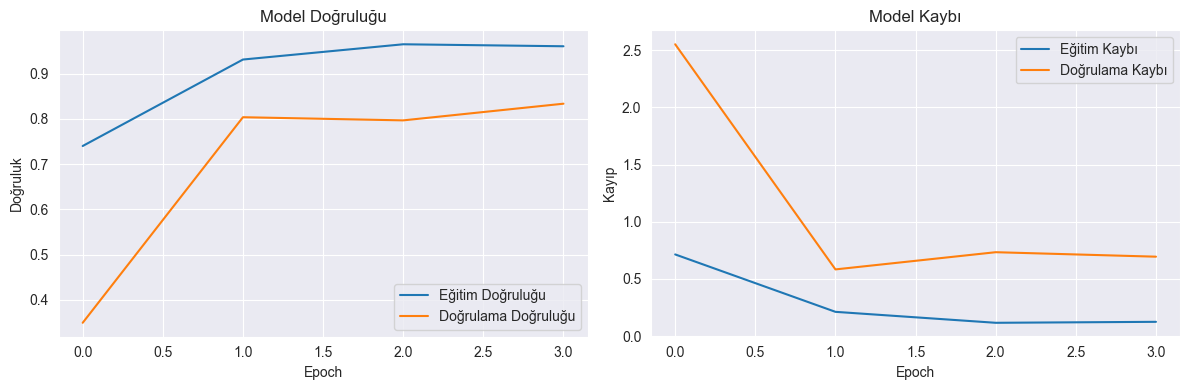

In [9]:
# Eğitim sonuçlarını görselleştir
plt.figure(figsize=(12, 4))#12X4 LÜK GRAFİK PENCERESİ OLUŞTUR.

#Accuracy Greafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

#Loss grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.tight_layout()
plt.show()

Accuracy: 0.8675
F1 Score: 0.8653
ROC-AUC Score: 0.8949


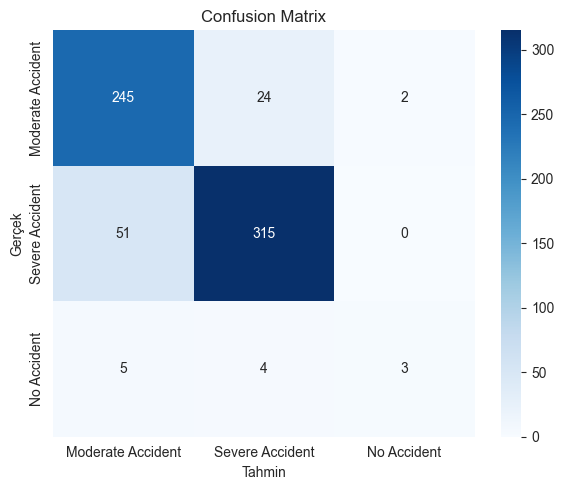


Sınıf Bazlı Performans:
                   precision    recall  f1-score   support

Moderate Accident       0.81      0.90      0.86       271
  Severe Accident       0.92      0.86      0.89       366
      No Accident       0.60      0.25      0.35        12

         accuracy                           0.87       649
        macro avg       0.78      0.67      0.70       649
     weighted avg       0.87      0.87      0.87       649



In [22]:
class_names = ['Moderate Accident', 'Severe Accident', 'No Accident']
utils.evaluate_model(model, test_dataset, class_names)

In [25]:
"""
test_image_paths = test_df['filename'].tolist()  # Test seti görüntü yolları
# Tahminlerin görselleştirilmesi
utils.visualize_predictions(
    model=model,
    image_paths=test_image_paths,
    class_names=class_names,
    num_images=5
)
"""

"\ntest_image_paths = test_df['filename'].tolist()  # Test seti görüntü yolları\n# Tahminlerin görselleştirilmesi\nutils.visualize_predictions(\n    model=model,\n    image_paths=test_image_paths,\n    class_names=class_names,\n    num_images=5\n)\n"